# QF605 Fixed-Income Securities
## Part 1 - Bootstrapping Swap Curves
#### Prepared by: Zhang Shuxin, Jiang Shuang, Ong Shi Xin, Victor Kow, Wang Bo, Ankit Rawat, Sun Jianyun

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, brentq

import warnings
warnings.filterwarnings("ignore")

In [71]:
data=pd.read_excel('IR Data.xlsx',sheet_name='OIS')

In [72]:
data['Tenor'] = data['Tenor'].apply(lambda x: (float(x[0:-1])/12 if x[-1] == 'm' else float((x[0:-1]))))

### 1. OIS Calibration

In [73]:
# calculate the discount_factor for the tenor 0.5
DF_ = [1/(1+0.5*data.Rate[0])]

In [74]:
# focous on the tenor
tenor_list = [1, 2, 3, 4, 5, 7, 10, 15, 20, 30]
OIS_list = list(data.Rate[1:])
DF = []

In [75]:
def interpolate(T, pre_tenor, DF_new, DF):
    missing_tenor = list(range(pre_tenor + 1, T))
    return np.interp(missing_tenor, [pre_tenor, T], [DF[-1], DF_new])

In [76]:
def discount_factor(DF_new, T):
    DF_sum = sum(DF)
    if T <= 5:
        Fix = (DF_sum + DF_new) * OIS_list[tenor_list.index(T)]
    else:
        pre_tenor = tenor_list[tenor_list.index(T)-1]
        DF_inter = interpolate(T, pre_tenor, DF_new, DF)
        Fix = (DF_sum + DF_new + DF_inter.sum())* OIS_list[tenor_list.index(T)]
    Float = 1 - DF_new
    return Fix - Float

In [77]:
for i in tenor_list:
    DF_new = brentq(lambda x: discount_factor(x, i), 0.1, 1)
    if i <=5:
        DF.append(DF_new)
    else:
        pre_tenor = tenor_list[tenor_list.index(i)-1]
        inter = interpolate(i, pre_tenor, DF_new, DF)
        DF.extend(inter)
        DF.append(DF_new)

In [78]:
DF_list = []
for x in tenor_list:
    DF_list.append(DF[x-1])

In [79]:
# get the discount factor list from tenor 0.5, 1, till 30
DF_.extend(DF_list)

In [80]:
OIS_DF_table = pd.DataFrame({'Tenor': data.Tenor, 'OIS': data.Rate, 'OIS_DF':DF_})
OIS_DF_table

,Tenor,OIS,OIS_DF
0,0.5,0.00250,0.998752
1,1.0,0.00300,0.997009
2,2.0,0.00325,0.993531
3,3.0,0.00335,0.990015
4,4.0,0.00350,0.986117
5,5.0,0.00360,0.982184
6,7.0,0.00400,0.972406
7,10.0,0.00450,0.955977
8,15.0,0.00500,0.927611
9,20.0,0.00525,0.900076


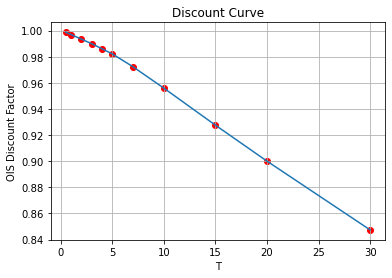

In [81]:
plt.scatter(data.Tenor, DF_, c = 'r')
plt.plot(data.Tenor, DF_)
plt.grid()
plt.ylabel('OIS Discount Factor')
plt.xlabel('T')
plt.title('Discount Curve');

### 2. Bootstrapping LIBOR discount curve

In [82]:
IRS =pd.read_excel('IR Data.xlsx',sheet_name='IRS')

In [83]:
IRS['Tenor'] = IRS['Tenor'].apply(lambda x: (float(x[0:-1])/12 if x[-1] == 'm' else float((x[0:-1]))))

In [84]:
# set up a new dataframe to store semi-annual discount factors
df=pd.DataFrame(np.zeros((60,2)),columns=['Tenor','OIS_DF'])
df['Tenor'] = np.linspace(0.5, 30, 60)

In [85]:
# store the yearly OIS discount factor in a dataframe
ois_df = pd.DataFrame([np.arange(1, 31), DF]).T
ois_df.rename(columns = {0: 'Tenor', 1:'ois_df'}, inplace = True)

In [86]:
df = df.set_index('Tenor')
ois_df = ois_df.set_index('Tenor')

In [87]:
df['OIS_DF'] = ois_df['ois_df']

In [88]:
# store in the 6m tenor OIS discount factor
df.iloc[0, 0] = 1/(1+0.5*data.Rate[0])

In [89]:
# interpolate to get the full OIS discount factor
df['OIS_DF'] = df['OIS_DF'].interpolate()
DF_OIS = df['OIS_DF'].tolist()

In [90]:
def interpolate_new(T, DF_new, DF_Libor):
    pre_tenor = tenor_list[tenor_list.index(T)-1]
    missing_tenor = np.arange(pre_tenor, T, 0.5)[1:]
    missing_DF = np.interp(missing_tenor, [pre_tenor, T], [DF_Libor[-1], DF_new])
    return missing_DF

In [91]:
# this is the funciton gonna use
def finding_new(T, DF_OIS, DF_Libor, DF_new):    
    
   
    DF_sum = sum(DF_OIS[:int(2*T)])
    
    Fix = 0.5 * DF_sum * IRS[IRS.Tenor == T]['Rate']
    
    
    if T == 0.5: 
        
        Float_sum = DF_OIS[0] * (1-DF_new)/DF_new 
    
    elif T == 1:
        Float1 = DF_OIS[0] * 0.025 * 0.5
        #Float1 = DF_OIS[0] * (1 - DF_Libor[0]) / DF_Libor[0]
        Float2 = DF_OIS[1] * (DF_Libor[-1] - DF_new) / DF_new
        Float_sum = Float1 + Float2
        
    else:
    
        dis_inter = interpolate_new(T, DF_new, DF_Libor)
        a = DF_Libor + list(dis_inter)
        
        Float1 = DF_OIS[0]*(1-a[0])/a[0]
        
        Float2 = 0
        
        for i in range(1, int(2*T-1)):
            
            Float2 += DF_OIS[i] * ((a[i-1] - a[i])/a[i])
    
    #Float3 = DF_OIS[T]*(DF_Libor[-1]-dis_inter[0])/dis_inter[0]
                
        Float_sum = Float1 + Float2 + DF_OIS[2*T-1] * ((a[-1] - DF_new) / DF_new)
            
    
    return Fix - Float_sum

In [92]:
tenor_list = [0.5, 1, 2, 3, 4, 5, 7, 10, 15, 20, 30]

In [93]:
DF_Libor = []
for i in tenor_list:
    df_new = brentq(lambda x : finding_new(i, DF_OIS, DF_Libor, x), 0.0001, 1)
    if i <= 1:
        DF_Libor.append(df_new)
    else:
        dis_inter = interpolate_new(i, df_new, DF_Libor)
        DF_Libor.extend(dis_inter)
        DF_Libor.append(df_new)

In [94]:
df['Libor_DF'] = DF_Libor

In [95]:
df = df.reset_index()

In [96]:
all_df = df.loc[df.Tenor.isin(IRS['Tenor'])]

In [97]:
all_df

,Tenor,OIS_DF,Libor_DF
0,0.5,0.998752,0.987654
1,1.0,0.997009,0.972577
3,2.0,0.993531,0.942179
5,3.0,0.990015,0.910482
7,4.0,0.986117,0.878981
9,5.0,0.982184,0.848989
13,7.0,0.972406,0.784216
19,10.0,0.955977,0.692710
29,15.0,0.927611,0.551081
39,20.0,0.900076,0.408218


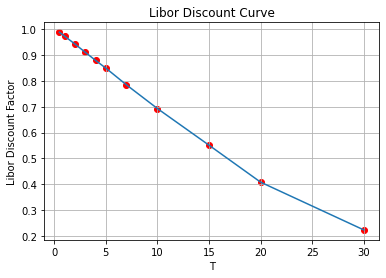

In [98]:
plt.plot(all_df.Tenor, all_df['Libor_DF'])
plt.scatter(all_df.Tenor,all_df['Libor_DF'], c = 'r')
plt.grid()
plt.ylabel('Libor Discount Factor')
plt.xlabel('T')
plt.title('Libor Discount Curve');

In [99]:
df.to_csv('discount_factor.csv', index = False)

### 3. Forward Swap Rate Calculations

In [100]:
Expiry = ['1Y', '5Y', '10Y']
Tenor = ['1Y', "2Y", '3Y', '5Y', '10Y']

In [101]:
fsw = []
for ex in Expiry:
    for te in Tenor:
        i = int(ex.strip()[:-1])
        j = int(te.strip()[:-1])
        deno = 0.5*sum(df.OIS_DF[2*i:2*(i+j)])
        
        terms = []
        for x in range(2*i, 2*(i+j)):
            no = df.OIS_DF[x] * (df.Libor_DF[x-1] - df.Libor_DF[x])/df.Libor_DF[x]
            terms.append(no)
        numer = sum(terms)
        
        fsw.append(numer/deno)

In [102]:
fsw_array = np.array(fsw).reshape(3, 5)
forward_swap = pd.DataFrame(fsw_array, columns = Tenor, index = Expiry)
forward_swap

,1Y,2Y,3Y,5Y,10Y
1Y,0.032007,0.033259,0.034011,0.035255,0.038428
5Y,0.039274,0.040075,0.040072,0.041093,0.043634
10Y,0.042189,0.043116,0.044097,0.046249,0.053458


In [103]:
forward_swap.to_csv('forward_swap_rate.csv')

### 4. Preparing for Part II

In [104]:
# get 2x10 forward swap rate
deno = 0.5*sum(df.OIS_DF[2*2:2*(2+10)])
        
terms = []
for x in range(2*2, 2*(2+10)):
    no = df.OIS_DF[x] * (df.Libor_DF[x-1] - df.Libor_DF[x])/df.Libor_DF[x]
    terms.append(no)
numer = sum(terms)
numer/deno

0.03963437677316925

In [105]:
# get 8x10 forward swap rate

deno = 0.5*sum(df.OIS_DF[2*8:2*(8+10)])
        
terms = []
for x in range(2*8, 2*(8+10)):
    no = df.OIS_DF[x] * (df.Libor_DF[x-1] - df.Libor_DF[x])/df.Libor_DF[x]
    terms.append(no)
numer = sum(terms)

numer/deno

0.04871114894211796

In [106]:
# saving yearly discount factor to csv
yearly_DF = df[df.Tenor % 1 == 0]
yearly_DF.to_csv('yearly_DF.csv')

In [107]:
#exit()